# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [11]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

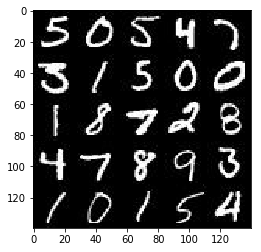

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

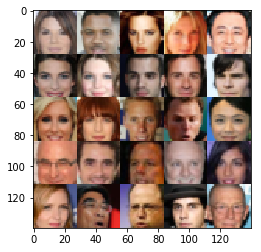

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real   = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat   = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out    = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                # sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


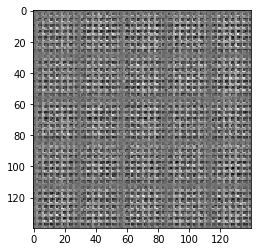

Epoch 1/2... Discriminator Loss: 0.3800... Generator Loss: 4.3420
Epoch 1/2... Discriminator Loss: 0.4667... Generator Loss: 2.5499
Epoch 1/2... Discriminator Loss: 0.3537... Generator Loss: 6.2418
Epoch 1/2... Discriminator Loss: 0.4876... Generator Loss: 8.9512
Epoch 1/2... Discriminator Loss: 0.9263... Generator Loss: 1.2919
Epoch 1/2... Discriminator Loss: 0.7614... Generator Loss: 2.2139
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 1.1374
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 1.5927
Epoch 1/2... Discriminator Loss: 1.5257... Generator Loss: 1.7962
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 1.4470


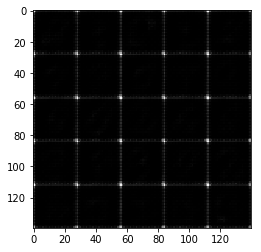

Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 0.8897
Epoch 1/2... Discriminator Loss: 1.5329... Generator Loss: 1.9423
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 1.5620
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.9700
Epoch 1/2... Discriminator Loss: 1.4931... Generator Loss: 1.6107
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.8524
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 1.5740
Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 1.3866
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.8582
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 1.2293


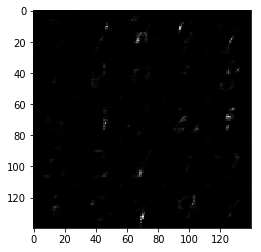

Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 1.1196
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 1.1140
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 1.2492
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 1.4638
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 0.7376
Epoch 1/2... Discriminator Loss: 1.1238... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 0.8447
Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 0.8735


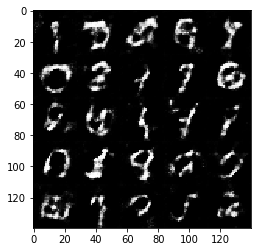

Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.8588
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 1.1579
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.8681
Epoch 1/2... Discriminator Loss: 1.4638... Generator Loss: 0.4512
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 1.6868
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.8123
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 0.6517
Epoch 1/2... Discriminator Loss: 1.1161... Generator Loss: 1.3530
Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 1.1208
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 1.0752


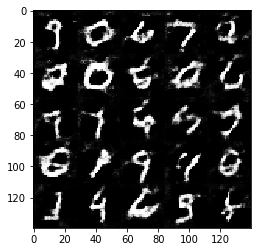

Epoch 1/2... Discriminator Loss: 1.0841... Generator Loss: 1.3506
Epoch 1/2... Discriminator Loss: 1.1416... Generator Loss: 0.8283
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 1.4330
Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 0.9819
Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 0.5623
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 1.1560
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 1.3277
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 1.9561
Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 1.0208
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 1.0776


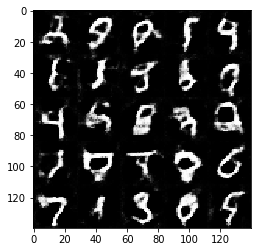

Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 0.7564
Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 0.8142
Epoch 2/2... Discriminator Loss: 1.4595... Generator Loss: 1.9363
Epoch 2/2... Discriminator Loss: 1.2943... Generator Loss: 0.6031
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 0.9232
Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 1.4001
Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 1.4076
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 1.9203
Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 0.7982


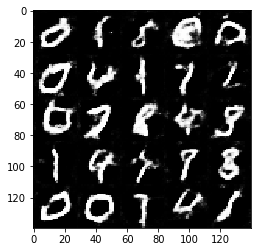

Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 0.5063
Epoch 2/2... Discriminator Loss: 1.1329... Generator Loss: 1.5792
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 0.7045
Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 0.9640
Epoch 2/2... Discriminator Loss: 1.0352... Generator Loss: 1.2151
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 1.2743
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 1.4302
Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 1.1513
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 1.4020


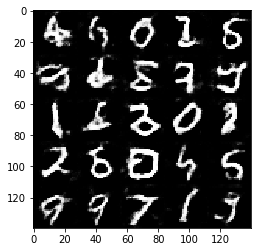

Epoch 2/2... Discriminator Loss: 1.0583... Generator Loss: 1.1686
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.6249
Epoch 2/2... Discriminator Loss: 1.0431... Generator Loss: 1.3276
Epoch 2/2... Discriminator Loss: 1.3607... Generator Loss: 0.5156
Epoch 2/2... Discriminator Loss: 1.1648... Generator Loss: 0.7515
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.6630
Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 0.6131
Epoch 2/2... Discriminator Loss: 1.0251... Generator Loss: 0.9447
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 1.9348
Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 0.7903


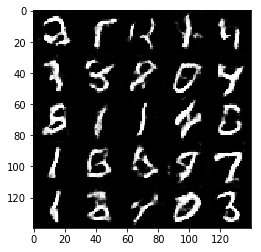

Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.6039
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 2.0756
Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 1.4843
Epoch 2/2... Discriminator Loss: 0.9530... Generator Loss: 1.2246
Epoch 2/2... Discriminator Loss: 1.5793... Generator Loss: 2.4760
Epoch 2/2... Discriminator Loss: 0.9386... Generator Loss: 1.2073
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 1.2825
Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 0.7430
Epoch 2/2... Discriminator Loss: 1.0873... Generator Loss: 0.7591


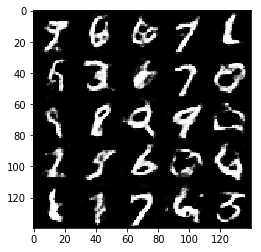

Epoch 2/2... Discriminator Loss: 1.4905... Generator Loss: 0.4691
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 1.2927
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.1661


In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


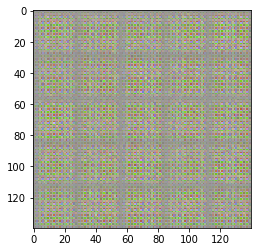

Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.6747
Epoch 1/1... Discriminator Loss: 0.5700... Generator Loss: 2.6910
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 10.1944
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 5.3212
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 3.4482
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 3.6505
Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 3.1528
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 1.6962
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.5922


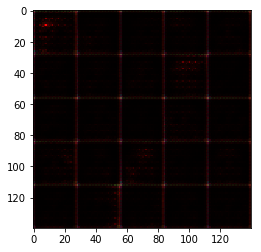

Epoch 1/1... Discriminator Loss: 0.4437... Generator Loss: 3.6002
Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 4.1746
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 3.9006
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 3.4460
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 2.4835
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 4.3548
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 1.8667
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 1.6893
Epoch 1/1... Discriminator Loss: 1.8264... Generator Loss: 0.3489
Epoch 1/1... Discriminator Loss: 2.7586... Generator Loss: 0.1363


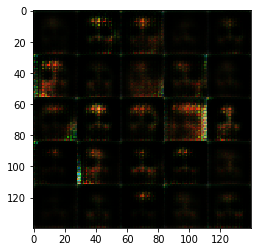

Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.2656
Epoch 1/1... Discriminator Loss: 1.6578... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 2.0820... Generator Loss: 0.2942
Epoch 1/1... Discriminator Loss: 1.8181... Generator Loss: 2.3848
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.4376
Epoch 1/1... Discriminator Loss: 2.6620... Generator Loss: 0.1317
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.8425... Generator Loss: 0.3076
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.0099


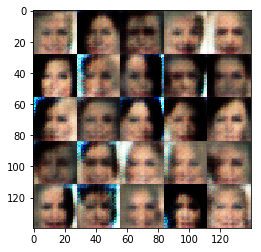

Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.7308
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 2.1466
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 2.5655... Generator Loss: 2.8137
Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 1.3967
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.5171


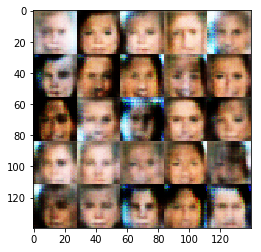

Epoch 1/1... Discriminator Loss: 1.6165... Generator Loss: 1.4240
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.4315
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.3488
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 1.5657
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.1735
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 2.5972
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.6274


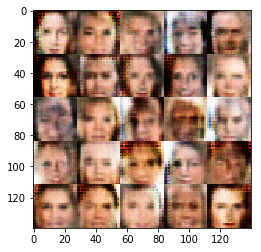

Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 1.5338
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.6168
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 1.8945
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 1.2843
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 1.4125


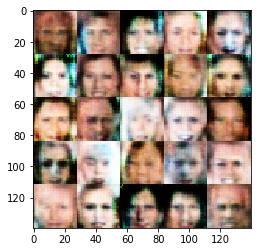

Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.6170
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 2.5272... Generator Loss: 0.1514


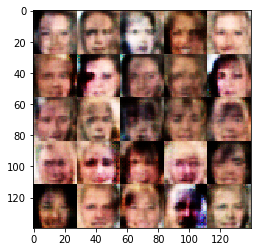

Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.5595
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.5246


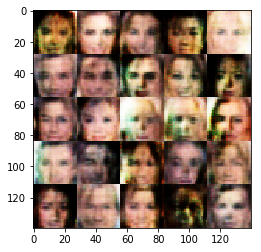

Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.8315
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 1.8494
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.5110
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 1.2709
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 2.1936


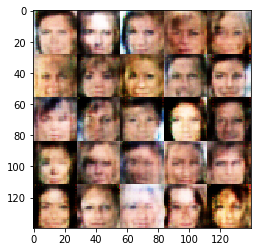

Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.6184... Generator Loss: 0.3754
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 2.4445
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 2.4619
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 2.2264
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.2417


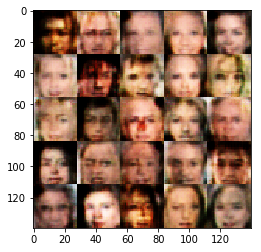

Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.8871... Generator Loss: 0.2702
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 2.2120
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 1.8360
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.3713


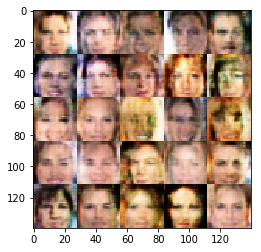

Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.4034
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.3596
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.0742


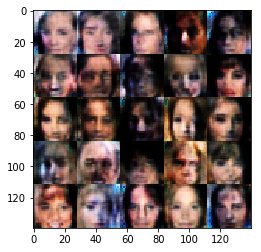

Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 2.1205... Generator Loss: 2.2431
Epoch 1/1... Discriminator Loss: 0.7269... Generator Loss: 1.7170
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.3110
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.4811
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.9566
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.3194


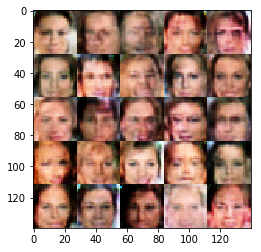

Epoch 1/1... Discriminator Loss: 1.6723... Generator Loss: 2.0095
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.4278
Epoch 1/1... Discriminator Loss: 0.6050... Generator Loss: 1.8454
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.7842
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 0.9217


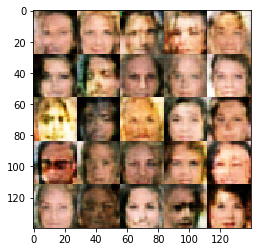

Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 1.4785
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 1.5788
Epoch 1/1... Discriminator Loss: 1.8779... Generator Loss: 0.2799
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 2.1665
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.4142
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.1328


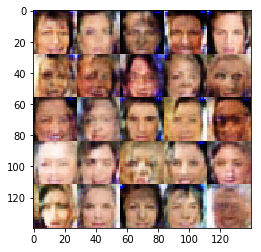

Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.4191
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 1.8829
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 1.5286
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.2309


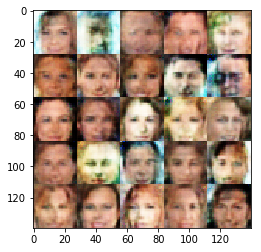

Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.4367
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.6830
Epoch 1/1... Discriminator Loss: 1.7084... Generator Loss: 0.3300
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.1957
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.5658
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.8079
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.8308


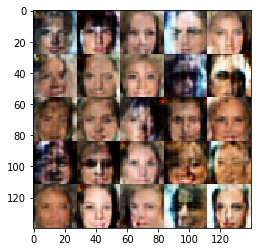

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.2078
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 1.1495
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.3312
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.9379


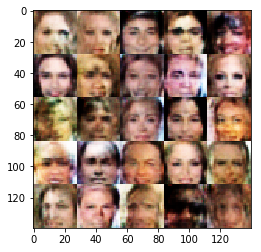

Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 1.3440
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 1.8200
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.0893
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.6810


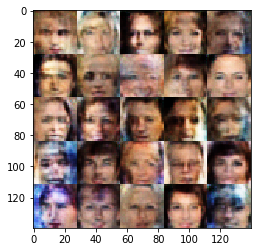

Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 2.1954
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.2876
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 1.6735


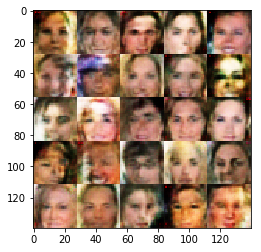

Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.6223... Generator Loss: 1.8413
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 3.1025
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.5143


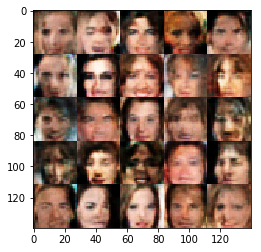

Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.2844
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.4146


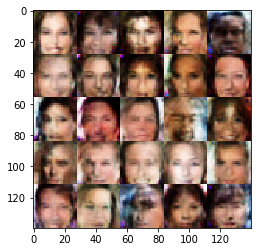

Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 1.8845
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.4564
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 1.8810
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 1.4184
Epoch 1/1... Discriminator Loss: 2.1734... Generator Loss: 0.2044


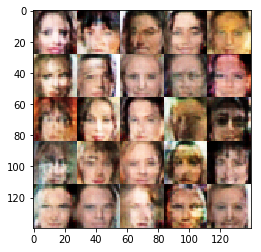

Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 1.6398... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.6508... Generator Loss: 1.9251
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 1.6816
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.2113


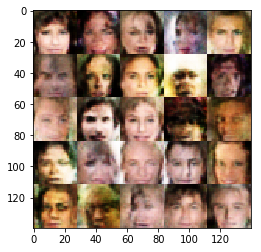

Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 2.1603
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 1.6347
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.1205
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 1.5275
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.2793
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6011


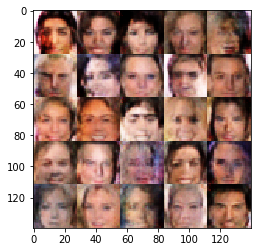

Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.8154... Generator Loss: 2.7478


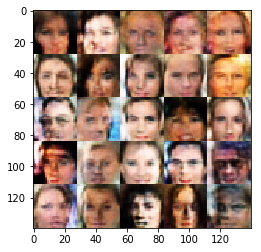

Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 1.3574
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.5922


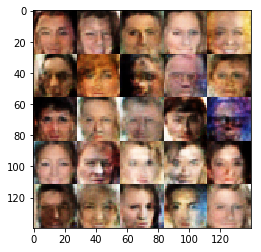

Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 3.5547
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.4482
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6048


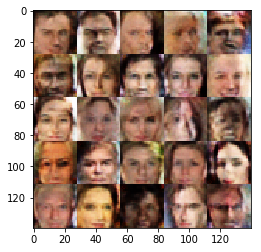

Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 1.7087
Epoch 1/1... Discriminator Loss: 1.6501... Generator Loss: 0.3573


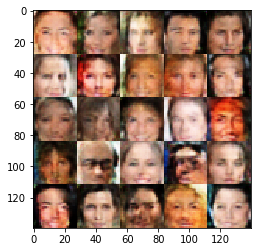

Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 1.5452
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 2.1530
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8704


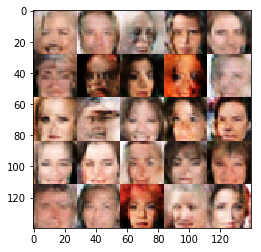

Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.1945
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.9127
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.4343
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 1.5368
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.8187


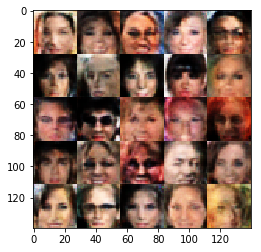

Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.1810


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.